In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import skew
from scipy.stats import boxcox

In [3]:
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')

In [4]:
# Total number of orders per customer
user_order_counts = orders.groupby('user_id').size().reset_index(name='total_orders')

# Average lag (in days) between orders per customer
user_order_lag = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index(name='avg_days_between_orders')

# Average size of orders (in products) per customer
# First, count products per order
order_sizes = order_products_prior.groupby('order_id').size().reset_index(name='order_size')
# Merge with orders to get user_id for each order
order_sizes = order_sizes.merge(orders[['order_id', 'user_id']], on='order_id')
# Then, average order size per user
user_avg_order_size = order_sizes.groupby('user_id')['order_size'].mean().reset_index(name='avg_order_size')

# Merge all features into a single DataFrame
user_features = user_order_counts.merge(user_order_lag, on='user_id').merge(user_avg_order_size, on='user_id')

user_features.head(n=10)

# total_orders and avg_days_between_orders are similar to recency and frequency --> will tell us how often the user uses Instacart
# avg_order size could be correlated to amount spent in an order (on average) --> monetary value

,user_id,total_orders,avg_days_between_orders,avg_order_size
0,1,11,19.000000,5.900000
1,2,15,16.285714,13.928571
2,3,13,12.000000,7.333333
3,4,6,17.000000,3.600000
4,5,5,11.500000,9.250000
5,6,4,13.333333,4.666667
6,7,21,10.450000,10.300000
7,8,4,23.333333,16.333333
8,9,4,22.000000,25.333333
9,10,6,21.800000,28.600000


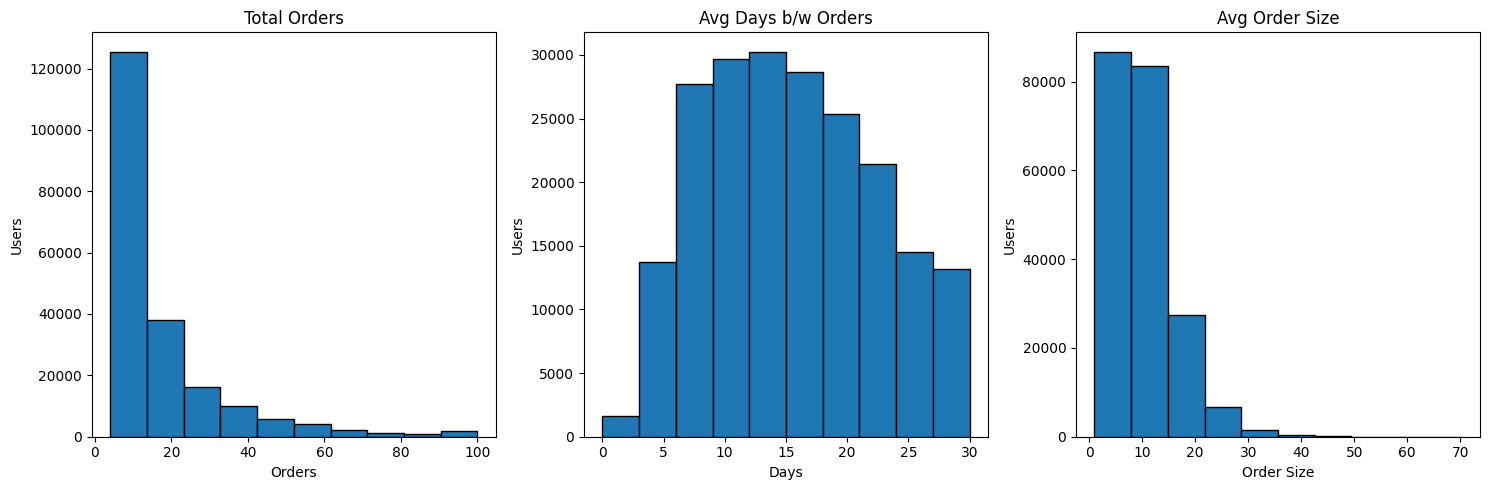

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(user_features['total_orders'], bins=10, edgecolor='black')
axes[0].set_title('Total Orders')
axes[0].set_xlabel('Orders')
axes[0].set_ylabel('Users')

axes[1].hist(user_features['avg_days_between_orders'], bins=10, edgecolor='black')
axes[1].set_title('Avg Days b/w Orders')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Users')

axes[2].hist(user_features['avg_order_size'], bins=10, edgecolor='black')
axes[2].set_title('Avg Order Size')
axes[2].set_xlabel('Order Size')
axes[2].set_ylabel('Users')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

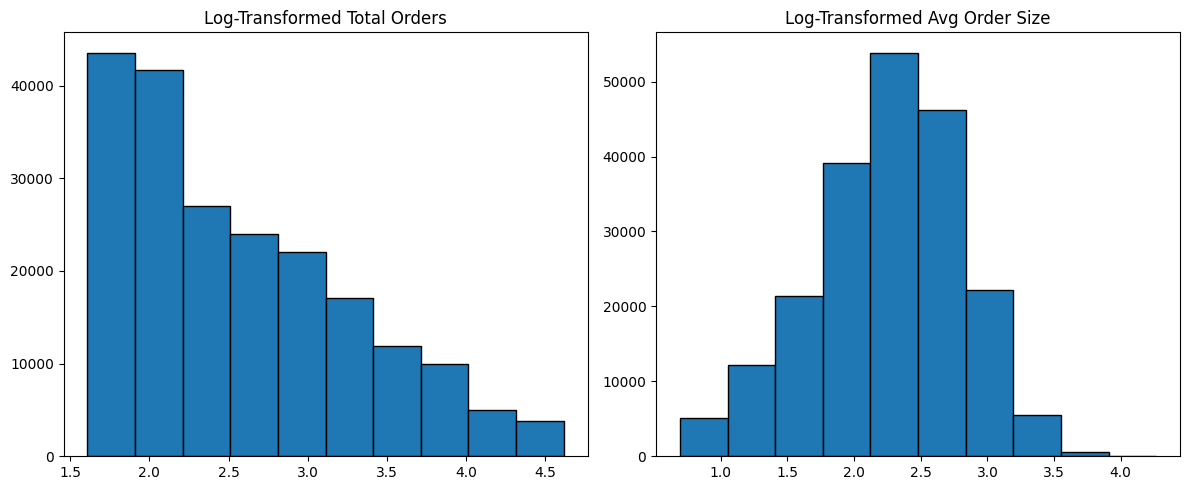

In [8]:
# Log Transformation

# Add 1 to avoid log(0)
user_features['log_total_orders'] = np.log1p(user_features['total_orders'])
user_features['log_avg_order_size'] = np.log1p(user_features['avg_order_size'])

# Optional: plot histograms to check the effect
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(user_features['log_total_orders'], bins=10, edgecolor='black')
axes[0].set_title('Log-Transformed Total Orders')
axes[1].hist(user_features['log_avg_order_size'], bins=10, edgecolor='black')
axes[1].set_title('Log-Transformed Avg Order Size')
plt.tight_layout()
plt.show()

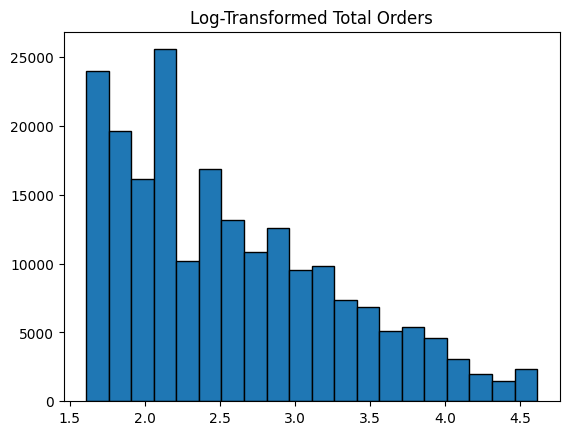

0.6499709926033933


In [9]:
plt.hist(user_features['log_total_orders'], bins=20, edgecolor='black')
plt.title('Log-Transformed Total Orders')
plt.show()

print(user_features['log_total_orders'].skew())

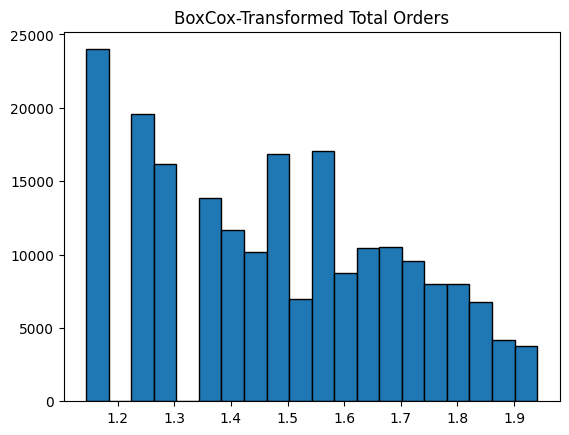

0.11904536231640603


In [10]:
# Since log_total_orders still seems right-skewed, let's perform a 
# different transformation (like Box-Cox)

# Only works for strictly positive values
user_features['boxcox_total_orders'], _ = boxcox(user_features['total_orders'] + 1)

plt.hist(user_features['boxcox_total_orders'], bins=20, edgecolor='black')
plt.title('BoxCox-Transformed Total Orders')
plt.show()

from scipy.stats import skew
print(user_features['boxcox_total_orders'].skew())

# Better than log-transformed total orders
# Therefore, the columns to use are boxcox_total_orders, avg_days_between_orders, and 
# log_avg_order_size

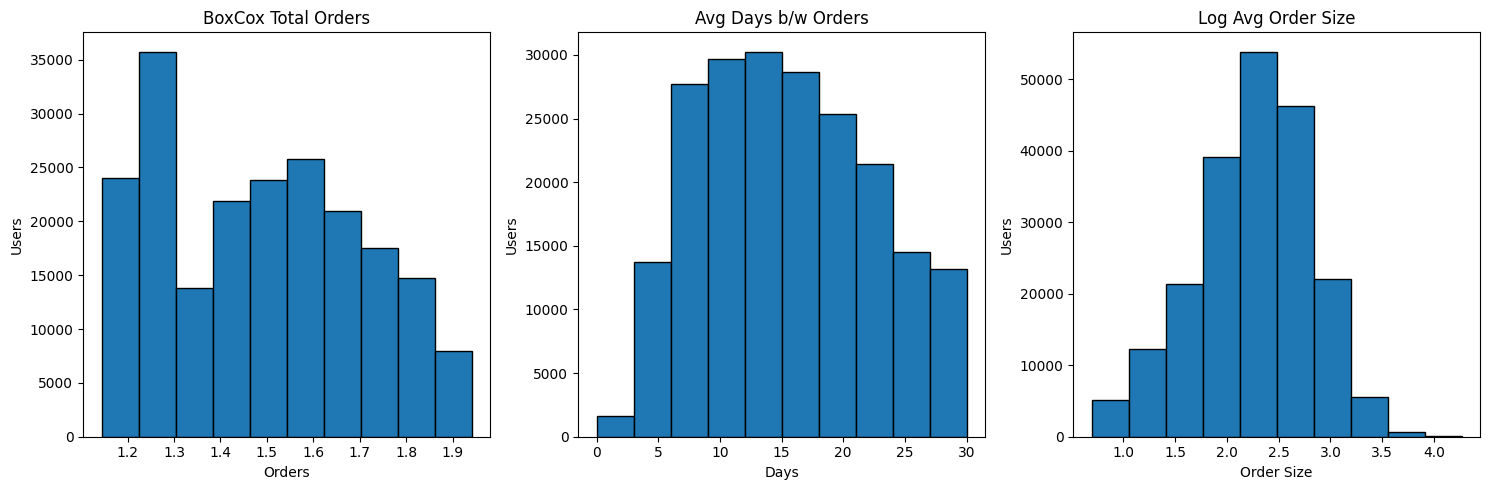

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(user_features['boxcox_total_orders'], bins=10, edgecolor='black')
axes[0].set_title('BoxCox Total Orders')
axes[0].set_xlabel('Orders')
axes[0].set_ylabel('Users')

axes[1].hist(user_features['avg_days_between_orders'], bins=10, edgecolor='black')
axes[1].set_title('Avg Days b/w Orders')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Users')

axes[2].hist(user_features['log_avg_order_size'], bins=10, edgecolor='black')
axes[2].set_title('Log Avg Order Size')
axes[2].set_xlabel('Order Size')
axes[2].set_ylabel('Users')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

In [12]:
clustering_features_trans = user_features[['boxcox_total_orders', 'avg_days_between_orders', 'log_avg_order_size']]

# Handle missing values in clustering features
#clustering_features = clustering_features.fillna(0)  # Fill NaNs with 0
print(clustering_features_trans)

clustering_features_trans.isna().sum()  # There are no NaN values --> do not need to fill or drop


        boxcox_total_orders  avg_days_between_orders  log_avg_order_size
0                  1.494345                19.000000            1.931521
1                  1.582315                16.285714            2.703277
2                  1.542899                12.000000            2.120264
3                  1.295399                17.000000            1.526056
4                  1.229026                11.500000            2.327278
...                     ...                      ...                 ...
206204             1.144328                16.666667            2.456736
206205             1.888833                 3.716418            1.658939
206206             1.615166                14.312500            2.703875
206207             1.840855                 7.367347            2.695730
206208             1.563561                18.461538            2.390878

[206209 rows x 3 columns]


boxcox_total_orders        0
avg_days_between_orders    0
log_avg_order_size         0
dtype: int64

[[ 0.06012953  0.51352523 -0.57815795]
 [ 0.45730004  0.12103549  0.82056583]
 [ 0.27934418 -0.49868517 -0.23608317]
 ...
 [ 0.6056151  -0.16429423  0.82164947]
 [ 1.62455698 -1.16857368  0.80688733]
 [ 0.37262781  0.4356629   0.25437587]]
[0.06012953 0.45730004 0.27934418 ... 0.6056151  1.62455698 0.37262781]
[-1.53545650e-15 -2.46577202e-16 -6.13893156e-16]
[1. 1. 1.]


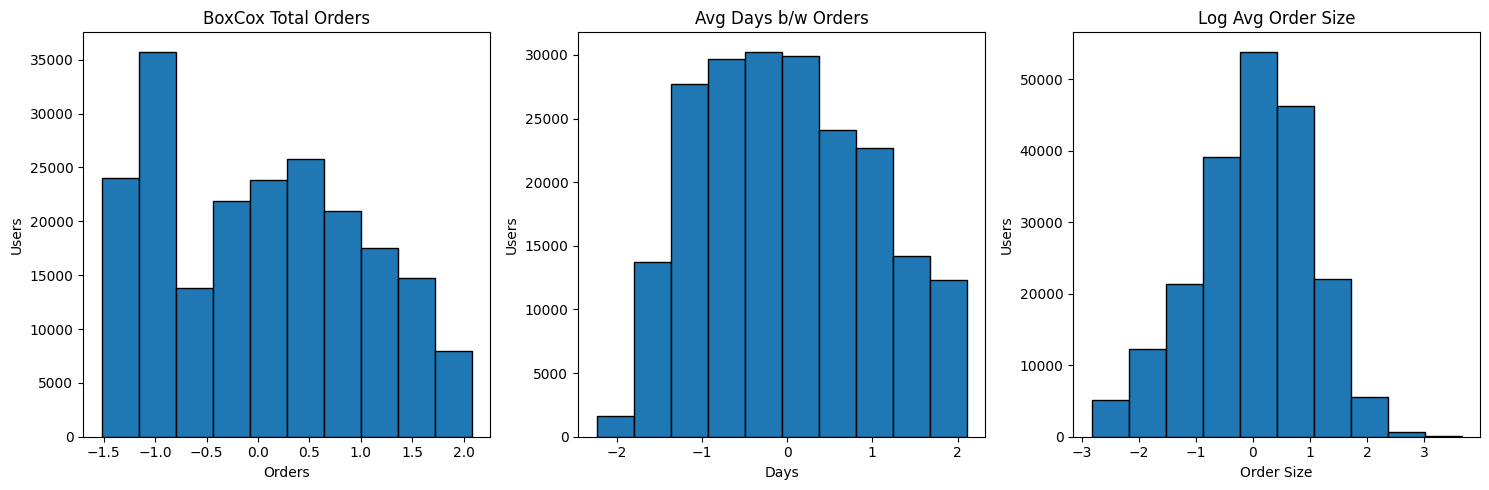

In [13]:
# Standardize features
scaler = StandardScaler()
clustering_features_trans_scaled = scaler.fit_transform(clustering_features_trans)

print(clustering_features_trans_scaled)

print(clustering_features_trans_scaled[:,0])

print(clustering_features_trans_scaled.mean(axis=0))  # Should be close to 0
print(clustering_features_trans_scaled.std(axis=0))  # Should be close to 1

# Plot Standarized features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(clustering_features_trans_scaled[:,0], bins=10, edgecolor='black')
axes[0].set_title('BoxCox Total Orders')
axes[0].set_xlabel('Orders')
axes[0].set_ylabel('Users')

axes[1].hist(clustering_features_trans_scaled[:,1], bins=10, edgecolor='black')
axes[1].set_title('Avg Days b/w Orders')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Users')

axes[2].hist(clustering_features_trans_scaled[:,2], bins=10, edgecolor='black')
axes[2].set_title('Log Avg Order Size')
axes[2].set_xlabel('Order Size')
axes[2].set_ylabel('Users')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

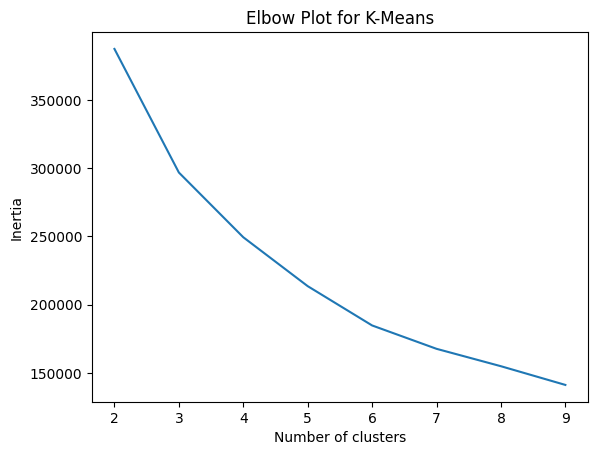

In [14]:
# Elbow method to determine optimal number of clusters
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_features_trans_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(2,10), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means')
plt.show()

In [15]:
# Based on elbow plot, k = 3 seems best
kmeans = KMeans(n_clusters=3, random_state=42)
user_features['cluster'] = kmeans.fit_predict(clustering_features_trans_scaled)
user_features.head(n=10)
# print(user_features['cluster_trans'].value_counts())
# cluster 0 - 83209, cluster 2 - 72172, cluster 1 - 50828

,user_id,total_orders,avg_days_between_orders,avg_order_size,log_total_orders,log_avg_order_size,boxcox_total_orders,cluster
0,1,11,19.000000,5.900000,2.484907,1.931521,1.494345,1
1,2,15,16.285714,13.928571,2.772589,2.703277,1.582315,2
2,3,13,12.000000,7.333333,2.639057,2.120264,1.542899,0
3,4,6,17.000000,3.600000,1.945910,1.526056,1.295399,1
4,5,5,11.500000,9.250000,1.791759,2.327278,1.229026,2
5,6,4,13.333333,4.666667,1.609438,1.734601,1.144328,1
6,7,21,10.450000,10.300000,3.091042,2.424803,1.667269,0
7,8,4,23.333333,16.333333,1.609438,2.852631,1.144328,2
8,9,4,22.000000,25.333333,1.609438,3.270836,1.144328,2
9,10,6,21.800000,28.600000,1.945910,3.387774,1.295399,2


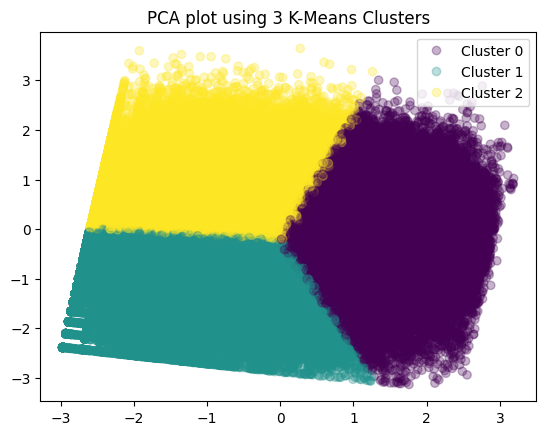

In [ ]:
# Visualize clusters using PCA
# PCA - dimensionality reduction, clusters are close together but similarly sized
# K-Means yielded decent clustering
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_features_trans_scaled)
user_features['pca1'] = pca_result[: ,0]
user_features['pca2'] = pca_result[: ,1]
scatter = plt.scatter(x='pca1', y='pca2', c='cluster', data=user_features, alpha=0.3)
classes = ['Cluster 0', 'Cluster 1', 'Cluster 2']
plt.title('PCA plot using 3 K-Means Clusters')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

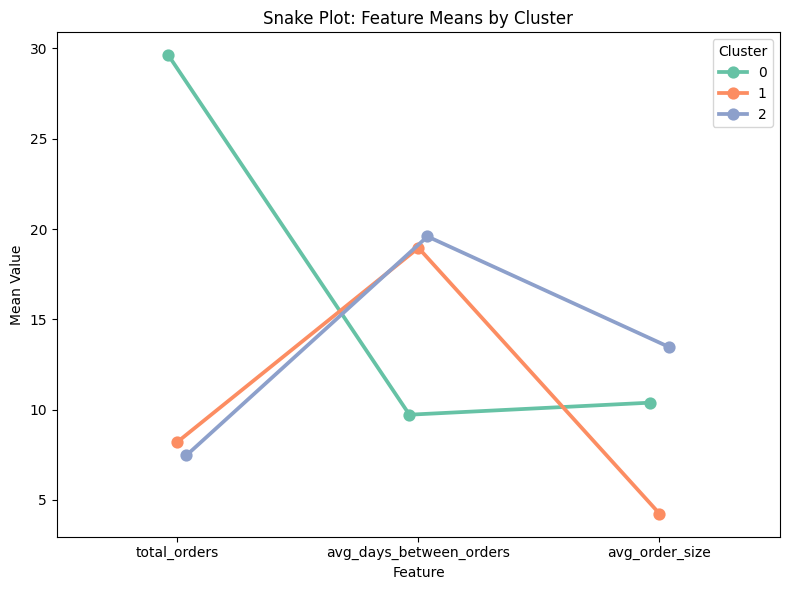

In [ ]:
# Features to plot
features = ['total_orders', 'avg_days_between_orders', 'avg_order_size']
# features_trans = ['boxcox_total_orders', 'avg_days_between_orders', 'log_avg_order_size']

# Calculate mean of each feature for each cluster
cluster_means = user_features.groupby('cluster')[features].mean().reset_index()

# Melt the DataFrame for seaborn pointplot
cluster_means_melted = cluster_means.melt(id_vars='cluster', var_name='feature', value_name='mean_value')

plt.figure(figsize=(8, 6))
sns.pointplot(data=cluster_means_melted, x='feature', y='mean_value', hue='cluster', palette='Set2', dodge=True)
plt.title('Snake Plot: Feature Means by Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Feature')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

Cluster 0 - make many, medium-sized purchases on instacart --> loyal customers

Cluster 1 - make few, small purchases on instacart --> probably specific shoppers or don't use instacart often
- would want to encourage them to shop more often/more products

Cluster 2 - make few, medium-sized purchases on instacart --> probably moderate shoppers
- would want to encourage them to shop more often as well